In [1]:
# Transfer Learning
# we will take a deeper look at how to finetune and feature extract the torchvision models, all of which have been pretrained on the 1000-class Imagenet dataset.
# this will give an indepth look at how to work with several modern CNN architectures, and will build an intuition for finetuning any PyTorch model.
# since each model architecture is different, there is no boilerplate finetuning code that will work in all scenarios. Rather, the researcher must look at the existing architecture and make custom adjustments for each model.

# Two types of transfer learning: finetuning and feature extraction
    # In finetuning, we start with a pretrained model and update all of the model’s parameters for our new task, in essence retraining the whole model.
    #  In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer.

# In general both transfer learning methods follow the same few steps:
    # Initialize the pretrained model
    # Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
    # Define for the optimization algorithm which parameters we want to update during training
    # Run the training step

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [3]:
# Inputs

# we assume the format of the directory conforms to the ImageFolder structure
data_dir = './hymenoptera_data'
model_name = "squeezenet"    # [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 2
batch_size = 8    # change depending on how much memory you have
num_epochs = 15

# If feature_extract = False, the model is finetuned and all model parameters are updated.
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
feature_extract = True

In [4]:
# Model training and validation code

# The is_inception flag is used to accomodate the Inception v3 model, as that architecture uses an auxiliary output and the overall model loss respects both the auxiliary output and the final output

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()    # Set model to training mode
            else:
                model.eval()     # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history only if train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output.
                    # In train mode we calculate the loss by summing the final output and the auxiliary output
                    # but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss +=loss.item()*inputs.size(0)
                running_corrects +=torch.sum(preds==labels.data)
            
            epoch_loss = running_loss/len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()/len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
    

In [5]:
# Set Model Parameters’ .requires_grad attribute
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Initialize and Reshape the networks
# Reshaping is not an automatic procedure and is unique to each model
# The goal here is to reshape the last layer to have the same number of inputs as before, and to have the same number of outputs as the number of classes in the dataset.
# notice that inception_v3 requires the input size to be (299,299), whereas all of the other models expect (224,224).

# Resnet
# There are several variants of different sizes, including Resnet18, Resnet34, Resnet50, Resnet101, and Resnet152.
# the last layer is a fully connected layer

# Alexnet
# When we print the model architecture, we see the model output comes from the 6th layer of the classifier.

# VGG
# When we print the model architecture, we see the model output comes from the 6th layer of the classifier.

# Squeezenet
# uses a different output structure than any of the other models shown here.
# Torchvision has two versions of Squeezenet, we use version 1.0.
# The output comes from a 1x1 convolutional layer which is the 1st layer of the classifier
# To modify the network, we reinitialize the Conv2d layer to have an output feature map of depth 2 as

# Densenet
# Torchvision has four variants of Densenet but here we only use Densenet-121. The output layer is a linear layer with 1024 input features

# Inception_v3
# This network is unique because it has two output layers when training.
# The second output is known as an auxiliary output and is contained in the AuxLogits part of the network.
# The primary output is a linear layer at the end of the network.
# Note, when testing we only consider the primary output.

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_fltrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_fltrs, num_classes)
        input_size = 224
    
    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_fltrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_fltrs, num_classes)
        input_size = 224
        
    elif model_name == "vgg":
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_fltrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_fltrs, num_classes)
        input_size = 224
        
    elif model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.num_classes = num_classes
        input_size = 224
    
    elif model_name == "densenet":
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_fltrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_fltrs, num_classes)
        input_size = 224
        
    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_fltrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_fltrs, num_classes)
        # Handle the primary net
        num_fltrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_fltrs, num_classes)
        input_size = 299
    
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just initialized
print(model_ft)

Z:\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
Z:\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [7]:
# Load Data
# now we know what should be the input size must be, we can initialize the data transforms, image datasets, and the dataloaders.
# notice, the models were pretrained with the hard-coded normalization values, as described here.

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [8]:
# Create the Optimizer

# send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run.
params_to_update = model_ft.parameters()
print("Parameters to learn: ")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
    
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

Parameters to learn: 
	 classifier.1.weight
	 classifier.1.bias


In [9]:
# Running training and validation step

# setup loss function
criterion = nn.CrossEntropyLoss()

# Train and Evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.7312 Acc: 0.6516
val Loss: 0.5726 Acc: 0.7255

Epoch 1/14
----------
train Loss: 0.4201 Acc: 0.8197
val Loss: 0.5286 Acc: 0.7778

Epoch 2/14
----------
train Loss: 0.3345 Acc: 0.8525
val Loss: 0.4564 Acc: 0.8170

Epoch 3/14
----------
train Loss: 0.3419 Acc: 0.8525
val Loss: 0.3931 Acc: 0.8497

Epoch 4/14
----------
train Loss: 0.2877 Acc: 0.8689
val Loss: 0.3521 Acc: 0.8693

Epoch 5/14
----------
train Loss: 0.2684 Acc: 0.8975
val Loss: 0.3714 Acc: 0.8889

Epoch 6/14
----------
train Loss: 0.2444 Acc: 0.9180
val Loss: 0.3828 Acc: 0.8954

Epoch 7/14
----------
train Loss: 0.2196 Acc: 0.9139
val Loss: 0.3511 Acc: 0.8954

Epoch 8/14
----------
train Loss: 0.2392 Acc: 0.9016
val Loss: 0.3598 Acc: 0.9020

Epoch 9/14
----------
train Loss: 0.2533 Acc: 0.8770
val Loss: 0.3703 Acc: 0.8824

Epoch 10/14
----------
train Loss: 0.1958 Acc: 0.8934
val Loss: 0.3985 Acc: 0.8954

Epoch 11/14
----------
train Loss: 0.2108 Acc: 0.9098
val Loss: 0.3652 Acc: 0.9085

Ep

In [10]:
# comparison with model trained from scratch
# lets see how the model learns if we do not use transfer learning.

# Initialize the non-pretrained version of the model used for this run
scratch_model, _ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs, is_inception=(model_name=="inception"))

Z:\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
Z:\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


Epoch 0/14
----------
train Loss: 0.7077 Acc: 0.5123
val Loss: 0.6931 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6927 Acc: 0.5369
val Loss: 0.6931 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.6924 Acc: 0.4959
val Loss: 0.6931 Acc: 0.4575

Epoch 3/14
----------
train Loss: 0.6911 Acc: 0.4959
val Loss: 0.6927 Acc: 0.5948

Epoch 4/14
----------
train Loss: 0.6988 Acc: 0.4467
val Loss: 0.6931 Acc: 0.4575

Epoch 5/14
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 6/14
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 7/14
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 8/14
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 9/14
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6931 Acc: 0.5082
val Loss: 0.6931 Acc: 0.4575

Ep

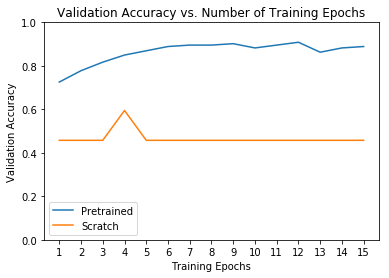

In [11]:
# Plot the training curves of validation accuracy vs. number of training epochs for the transfer learning method and the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1, num_epochs+1), ohist, label="Pretrained")
plt.plot(range(1, num_epochs+1), shist, label="Scratch")
plt.ylim((0, 1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [12]:
# Final thoughts
# notice that feature extracting takes less time because in the backward pass we do not have to calculate most of the gradients.